In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time

In [2]:
import pandas as pd
realDF = pd.read_csv('../data-processing/cresci-2017/genuine_accounts_processed.csv')
ss1DF = pd.read_csv('../data-processing/cresci-2017/social_spambots_1_processed.csv')
ss2DF = pd.read_csv('../data-processing/cresci-2017/social_spambots_2_processed.csv')
ss3DF = pd.read_csv('../data-processing/cresci-2017/social_spambots_3_processed.csv')
ffDF = pd.read_csv('../data-processing/cresci-2017/fake_followers_processed.csv')
ts1DF = pd.read_csv('../data-processing/cresci-2017/traditional_spambots_1_processed.csv')
coaDF = pd.read_csv('../data-processing/college-official-accounts/coa_processed.csv')
v2019DF = pd.read_csv('../data-processing/verified-2019/v2019_processed.csv')
vp2019DF = pd.read_csv('../data-processing/vp-2019/vp2019_processed.csv')
varol_realDF = pd.read_csv('../data-processing/varol-2017/varol_real_processed.csv')
varol_botDF = pd.read_csv('../data-processing/varol-2017/varol_bot_processed.csv')

In [3]:
# removing some entries from data
del coaDF['url_youtube'], v2019DF['url_youtube'], vp2019DF['url_youtube'], varol_botDF['url_youtube'], varol_realDF['url_youtube']
del coaDF['favorite'], realDF['favorite'], ss1DF['favorite'], ss2DF['favorite'], ss3DF['favorite'], ffDF['favorite'], ts1DF['favorite'], v2019DF['favorite'], vp2019DF['favorite'], varol_realDF['favorite'], varol_botDF['favorite']
del coaDF['Unnamed: 0'], realDF['Unnamed: 0'], ss1DF['Unnamed: 0'], ss2DF['Unnamed: 0'], ss3DF['Unnamed: 0'], ffDF['Unnamed: 0'], ts1DF['Unnamed: 0'], v2019DF['Unnamed: 0'], vp2019DF['Unnamed: 0'], varol_realDF['Unnamed: 0'], varol_botDF['Unnamed: 0']
del coaDF['favorite_over_friend'], realDF['favorite_over_friend'], ss1DF['favorite_over_friend'], ss2DF['favorite_over_friend'], ss3DF['favorite_over_friend'], ffDF['favorite_over_friend'], ts1DF['favorite_over_friend'], v2019DF['favorite_over_friend'], vp2019DF['favorite_over_friend'], varol_botDF['favorite_over_friend'], varol_realDF['favorite_over_friend']


In [4]:
def data_split (df, split=0.7):
    train_num = int(len(df.index)*split)
    return df.iloc[:train_num,:], df.iloc[train_num+1:,:]

In [5]:
def trainRF (reals, bots, n_estimators=100):

    data = pd.concat(reals+bots).fillna(0).to_numpy()
    target = np.array([0] * sum(len(real.index) for real in reals) + [1] * sum(len(bot.index) for bot in bots))
    rfc = RandomForestClassifier(n_estimators=n_estimators)
    rfc = rfc.fit(data, target)
    return rfc

In [32]:
def testRF(reals, bots, RF):
    data = pd.concat(reals+bots).fillna(0).to_numpy()
    target = np.array([0] * sum(len(real.index) for real in reals) + [1] * sum(len(bot.index) for bot in bots))
    print(data)
    print(target)
    return RF.score(data, target)

In [7]:
def testRF_ESC(reals, bots, RFs):
    data = pd.concat(reals+bots).fillna(0).to_numpy()
    target = np.array([0] * sum(len(real.index) for real in reals) + [1] * sum(len(bot.index) for bot in bots))
    totalAccNum = 0
    for i in range(data.shape[0]):
        catScore = [float(RFs[0].predict_proba([data[i]])[0][0])] + [float(RF.predict_proba([data[i]])[0][1]) for RF in RFs[1:]]
        if target[i] == 0 and catScore[0] == max(catScore) or target[i] == 1 and catScore[0] != max(catScore):
            totalAccNum += 1
        else:    
            print("Pred", i, target[i], catScore)
    return float(totalAccNum)/data.shape[0]

In [8]:
del coaDF['geo'], realDF['geo'], ss1DF['geo'], ss2DF['geo'], ss3DF['geo'], ffDF['geo'], ts1DF['geo'], v2019DF['geo'],vp2019DF['geo'], varol_botDF['geo'], varol_realDF['geo']

In [9]:
realTrain, realTest = data_split(realDF)
ss1Train, ss1Test = data_split(ss1DF)
ss2Train, ss2Test = data_split(ss2DF)
ss3Train, ss3Test = data_split(ss3DF)
ts1Train, ts1Test = data_split(ts1DF)
ffTrain, ffTest = data_split(ffDF)
coaTrain, coaTest = data_split(coaDF)
v2019Train, v2019Test = data_split(v2019DF)
vp2019Train, vp2019Test = data_split(vp2019DF)
varol_realTrain, varol_realTest = data_split(varol_realDF)
varol_botTrain, varol_botTest = data_split(varol_botDF)

In [11]:
print(coaTrain.shape, v2019Train.shape, vp2019Train.shape, varol_botTrain.shape, varol_realTrain.shape)

(2499, 47) (1367, 47) (477, 47) (445, 47) (862, 47)


In [12]:
no_cresci_2017_RF = trainRF([vp2019Train, varol_realTrain], [v2019Train, coaTrain, varol_botTrain])
print(testRF([vp2019Test, varol_realTest], [v2019Test, coaTest, varol_botTest], no_cresci_2017_RF))

0.9255890863993386


In [13]:
start_time = time.time()
importances = no_cresci_2017_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in no_cresci_2017_RF.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.009 seconds


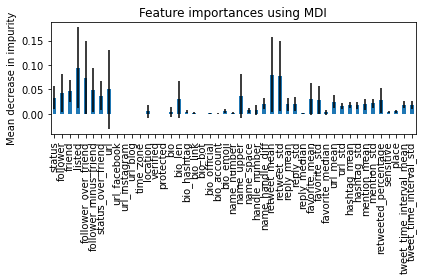

In [14]:
forest_importances = pd.Series(importances, index=realTrain.columns.values.tolist())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [15]:
real_detect_RF = []
real_detect_RF.append(trainRF([realTrain, varol_realTrain], [ss1Train, ss2Train, ss3Train, ffTrain, ts1Train, coaTrain, v2019Train, vp2019Train, varol_botTrain]))
real_detect_RF.append(trainRF([realTrain, varol_realTrain], [ss1Train, ss2Train, ss3Train]))
real_detect_RF.append(trainRF([realTrain, varol_realTrain], [ts1Train]))
real_detect_RF.append(trainRF([realTrain, varol_realTrain], [coaTrain]))
real_detect_RF.append(trainRF([realTrain, varol_realTrain], [ffTrain]))
real_detect_RF.append(trainRF([realTrain, varol_realTrain], [v2019Train]))
real_detect_RF.append(trainRF([realTrain, varol_realTrain], [vp2019Train]))
real_detect_RF.append(trainRF([realTrain, varol_realTrain], [varol_botTrain]))

In [16]:
print(testRF([realTest, varol_realTest], [ss1Test, ss2Test, ss3Test, ffTest, ts1Test, coaTest, v2019Test, vp2019Train, varol_botTest], real_detect_RF[0]))

0.9705114421747811


In [18]:
print(testRF([varol_realTest], [varol_botTest], real_detect_RF[0]))

0.7298747763864043


In [19]:
start_time = time.time()
importances = real_detect_RF[0].feature_importances_
std = np.std([tree.feature_importances_ for tree in real_detect_RF[0].estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.008 seconds


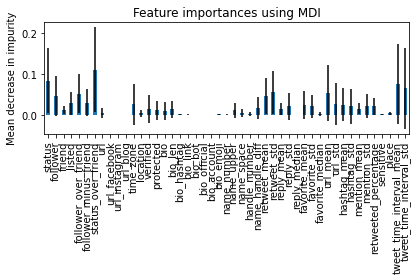

In [20]:
forest_importances = pd.Series(importances, index=realTrain.columns.values.tolist())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [22]:
correctRate = testRF_ESC([varol_realTest], [varol_botTest], real_detect_RF)

Pred 7 0 [0.1, 0.07, 0.01, 0.6, 0.0, 0.05, 0.08, 0.77]
Pred 10 0 [0.15, 0.07, 0.24, 0.26, 0.01, 0.0, 0.04, 0.68]
Pred 13 0 [0.01, 0.04, 0.0, 0.97, 0.0, 0.89, 0.27, 0.48]
Pred 14 0 [0.35, 0.06, 0.03, 0.57, 0.0, 0.0, 0.12, 0.76]
Pred 24 0 [0.34, 0.05, 0.01, 0.17, 0.02, 0.0, 0.08, 0.58]
Pred 27 0 [0.18, 0.05, 0.0, 0.69, 0.01, 0.02, 0.02, 0.42]
Pred 30 0 [0.31, 0.01, 0.0, 0.32, 0.0, 0.2, 0.03, 0.05]
Pred 31 0 [0.43, 0.0, 0.02, 0.29, 0.02, 0.09, 0.49, 0.1]
Pred 32 0 [0.35, 0.01, 0.02, 0.17, 0.05, 0.01, 0.35, 0.37]
Pred 42 0 [0.25, 0.01, 0.0, 0.42, 0.01, 0.02, 0.08, 0.52]
Pred 45 0 [0.06, 0.01, 0.0, 0.23, 0.01, 0.96, 0.33, 0.26]
Pred 47 0 [0.18, 0.05, 0.0, 0.64, 0.02, 0.02, 0.63, 0.11]
Pred 55 0 [0.4, 0.03, 0.0, 0.43, 0.01, 0.08, 0.15, 0.17]
Pred 59 0 [0.06, 0.02, 0.0, 0.72, 0.02, 0.99, 0.13, 0.38]
Pred 62 0 [0.19, 0.0, 0.0, 0.65, 0.0, 0.38, 0.07, 0.29]
Pred 66 0 [0.0, 0.06, 0.0, 0.52, 0.01, 0.99, 0.36, 0.42]
Pred 72 0 [0.1, 0.02, 0.0, 0.37, 0.02, 0.92, 0.52, 0.16]
Pred 76 0 [0.19, 0.08, 0.0

In [23]:
print(correctRate)

0.7513416815742398


In [24]:
varol_realDF.to_pickle('varol-real-pickled')
varol_botDF.to_pickle('varol-bot-pickled')

In [25]:
caverlee_realDF = pd.read_csv('../data-processing/caverlee/caverlee_real_processed.csv')
caverlee_botDF = pd.read_csv('../data-processing/caverlee/caverlee_real_processed.csv')

In [26]:
caverlee_realTrain, caverlee_realTest = data_split(caverlee_realDF)
caverlee_botTrain, caverlee_botTest = data_split(caverlee_botDF)

In [29]:
caverlee_RF = trainRF([caverlee_realTrain], [caverlee_botTrain])

In [33]:
print(testRF([caverlee_realTest], [caverlee_botTest], caverlee_RF))

[[0.00000000e+00 2.91000000e+02 1.24000000e+02 ... 9.00000000e+00
  1.97907035e+04 4.27191901e+04]
 [0.00000000e+00 5.48000000e+02 1.32000000e+02 ... 1.10000000e+01
  1.16786276e+04 1.54957107e+04]
 [0.00000000e+00 1.33900000e+03 8.40000000e+01 ... 1.30000000e+01
  1.69783417e+03 4.23880709e+03]
 ...
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 8.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+01
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 7.00000000e+00
  0.00000000e+00 0.00000000e+00]]
[0 0 0 ... 1 1 1]
0.5


In [34]:
caverlee_realDF.to_pickle('./caverlee-real-pickled')
caverlee_botDF.to_pickle('./caverlee-bot-pickled')

In [36]:
start_time = time.time()
importances = caverlee_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in caverlee_RF.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.032 seconds


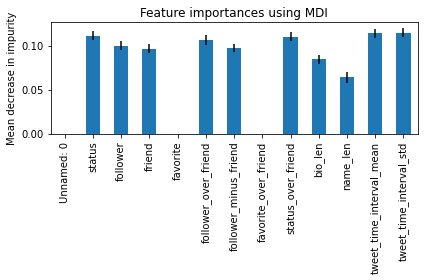

In [38]:
forest_importances = pd.Series(importances, index=caverlee_realTrain.columns.values.tolist())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()